# Instacart Market Basket Analysis - EDA & Modeling
By: Brandon Menendez

## Business Overview


- **Stakeholder:**
Instacart
- **Business Problem:**
Create a model that uses this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order

## Data Understanding

In [3]:
# Imports

import numpy as np
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, confusion_matrix,precision_score, recall_score,\
accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Read in  data

orders = pd.read_csv('orders.csv') 
orders_train = pd.read_csv('order_products__train.csv')
orders_prior = pd.read_csv('order_products__prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
depts = pd.read_csv('departments.csv')

## Data Exploration

In [5]:
# Visualizing dataframe

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1.0,2.0,8.0,NaN
1,2398795,1,prior,2.0,3.0,7.0,15.0
2,473747,1,prior,3.0,3.0,12.0,21.0
3,2254736,1,prior,4.0,4.0,7.0,29.0
4,431534,1,prior,5.0,4.0,15.0,28.0


In [6]:
# Checking for nulls 

orders.isna().sum()

order_id                      0
user_id                       0
eval_set                      1
order_number                  1
order_dow                     1
order_hour_of_day             1
days_since_prior_order    22490
dtype: int64

In [7]:
# Checking unique values 

orders.nunique()

order_id                  373266
user_id                    22489
eval_set                       3
order_number                 100
order_dow                      7
order_hour_of_day             24
days_since_prior_order        31
dtype: int64

In [8]:
# Checking order distribution between eval sets 

orders['eval_set'].value_counts()

prior    350777
train     14394
test       8094
Name: eval_set, dtype: int64

In [9]:
orders_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302.0,1.0,1.0
1,1,11109.0,2.0,1.0
2,1,10246.0,3.0,0.0
3,1,49683.0,4.0,0.0
4,1,43633.0,5.0,1.0


In [10]:
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28985.0,2.0,1.0
2,2,9327.0,3.0,0.0
3,2,45918.0,4.0,1.0
4,2,30035.0,5.0,0.0


In [11]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [13]:
# Merging  products + aisles + department into one df 

product_df = products.merge(aisles, how='left', left_on = 'aisle_id', right_on = 'aisle_id')
product_df = product_df.merge(depts, how='left', left_on='department_id', right_on='department_id')

# Dropping duplicative columns 

product_df.drop(columns=['aisle_id','department_id'],inplace=True)

product_df

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",spirits,alcohol
49684,49685,En Croute Roast Hazelnut Cranberry,frozen vegan vegetarian,frozen
49685,49686,Artisan Baguette,bread,bakery
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,cat food care,pets


In [14]:
# Inner join orders and orders_prior

orders_products = orders.merge(orders_prior,on='order_id',how='inner')

orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,23391,7,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0
1,23391,7,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0
2,23391,7,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0
3,23391,7,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0
4,23391,7,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0


In [15]:
orders_products[orders_products['order_number'] == 1]['reordered'].value_counts()

0.0    4615
Name: reordered, dtype: int64

In [16]:
# Observation: The first order_id  for every customer has null values for days_since_prior order and has 0 reorders
# for each customer. I believe its safe to assume this is each customers first order. 

In [17]:
orders_products.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
count,71782.000000,71782.000000,71782.000000,71782.000000,71782.000000,67167.000000,71782.000000,71782.000000,71782.000000
mean,34785.518932,11317.302081,17.705065,2.778106,13.418684,11.041821,25573.220668,8.236619,0.597601
std,20174.810007,6476.700931,17.769689,2.077039,4.229606,8.745148,14087.557862,6.997573,0.490385
min,6.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,17307.000000,5692.000000,5.000000,1.000000,10.000000,5.000000,13371.000000,3.000000,0.000000
50%,34810.000000,11465.000000,11.000000,3.000000,13.000000,8.000000,25407.000000,6.000000,1.000000
75%,52329.000000,16857.000000,25.000000,5.000000,16.000000,15.000000,37786.500000,11.000000,1.000000
max,69401.000000,22488.000000,99.000000,6.000000,23.000000,30.000000,49683.000000,60.000000,1.000000


In [18]:
orders_products =  orders_products.merge(product_df,how='left',left_on='product_id',right_on='product_id')

orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle,department
0,23391,7,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0,85% Lean Ground Beef,meat counter,meat seafood
1,23391,7,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0,Organic Apple Slices,fruit vegetable snacks,snacks
2,23391,7,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0,Apple Honeycrisp Organic,fresh fruits,produce
3,23391,7,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0,Mexican Coffee,coffee,beverages
4,23391,7,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0,Lactose Free Fat Free Milk,soy lactosefree,dairy eggs


In [19]:
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71782 entries, 0 to 71781
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                71782 non-null  int64  
 1   user_id                 71782 non-null  int64  
 2   eval_set                71782 non-null  object 
 3   order_number            71782 non-null  float64
 4   order_dow               71782 non-null  float64
 5   order_hour_of_day       71782 non-null  float64
 6   days_since_prior_order  67167 non-null  float64
 7   product_id              71782 non-null  float64
 8   add_to_cart_order       71782 non-null  float64
 9   reordered               71782 non-null  float64
 10  product_name            71782 non-null  object 
 11  aisle                   71782 non-null  object 
 12  department              71782 non-null  object 
dtypes: float64(7), int64(2), object(4)
memory usage: 7.7+ MB


In [20]:
orders_products.isna().sum()

order_id                     0
user_id                      0
eval_set                     0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    4615
product_id                   0
add_to_cart_order            0
reordered                    0
product_name                 0
aisle                        0
department                   0
dtype: int64

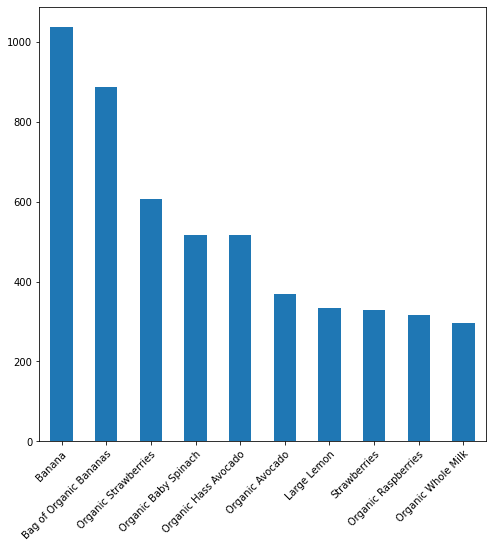

In [21]:
# Visualizing top ordered products 

fig, ax = plt.subplots(figsize=(8,8))

orders_products['product_name'].value_counts().head(10).plot(ax=ax, kind='bar')

plt.xticks(rotation = 45,ha='right', rotation_mode='anchor');

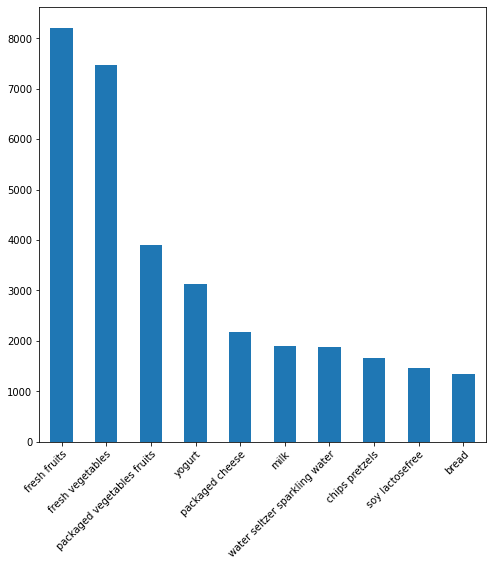

In [22]:
# Visualizing most ordered from aisles 

fig, ax = plt.subplots(figsize=(8,8))


orders_products['aisle'].value_counts().head(10).plot(ax=ax, kind='bar')

plt.xticks(rotation = 45,ha='right', rotation_mode='anchor');

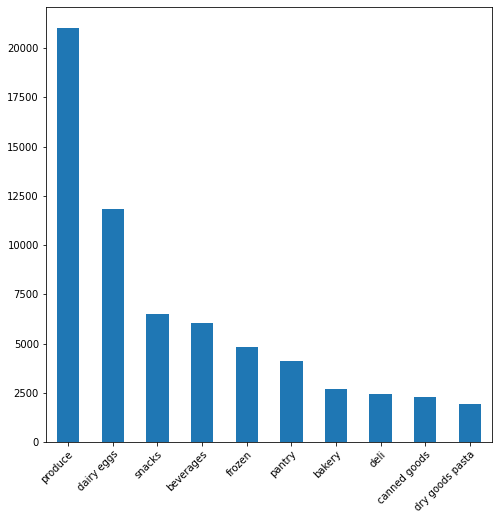

In [23]:
# Visualizing most ordered from departments 

fig, ax = plt.subplots(figsize=(8,8))

orders_products['department'].value_counts().head(10).plot(ax=ax, kind='bar')
plt.xticks(rotation = 45,ha='right', rotation_mode='anchor');

In [24]:
# Checking amount of unique order_ids and user_ids present in the prior df

unique_orders = orders_products['order_id'].nunique()
unique_users = orders_products['user_id'].nunique()

print(f"Orders: {unique_orders}, Users: {unique_users}")

Orders: 7207, Users: 5441


In [25]:
# Checking most frequent order day of the week 

orders_products['order_dow'].value_counts()

0.0    13234
1.0    12507
6.0     9929
5.0     9255
3.0     9168
4.0     9090
2.0     8599
Name: order_dow, dtype: int64

In [26]:
# Most frequent order days are Sunday, Monday & Saturday 

In [27]:
# Checking most common order hour 

orders_products['order_hour_of_day'].value_counts()

14.0    6240
10.0    6182
12.0    5960
11.0    5849
9.0     5741
16.0    5707
13.0    5696
15.0    5671
17.0    4924
8.0     3610
18.0    3537
19.0    2733
20.0    2255
7.0     2000
21.0    1501
22.0    1409
23.0     906
0.0      583
6.0      497
5.0      218
4.0      194
1.0      185
2.0      136
3.0       48
Name: order_hour_of_day, dtype: int64

In [28]:
# Most frequent order times tend to be in the morning/early afternoon. This makes sense as most people want to 
# get the groceries delivered when they get home 

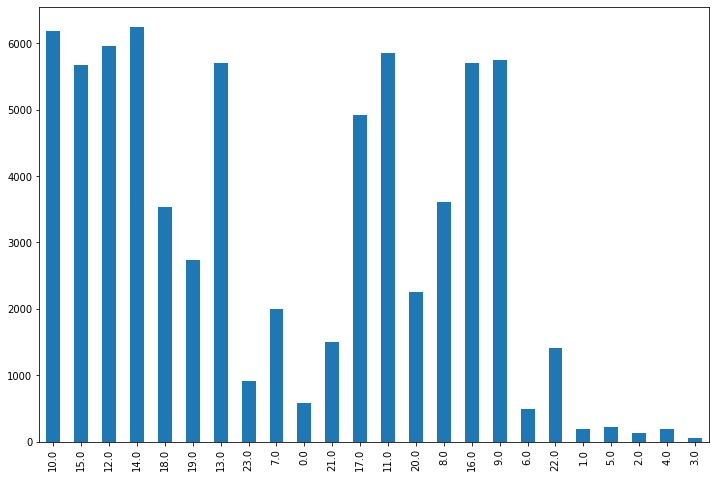

In [29]:
# Visualizing orders by time of day 

orders_products['order_hour_of_day'].value_counts(sort=False).plot.bar(figsize=(12,8));

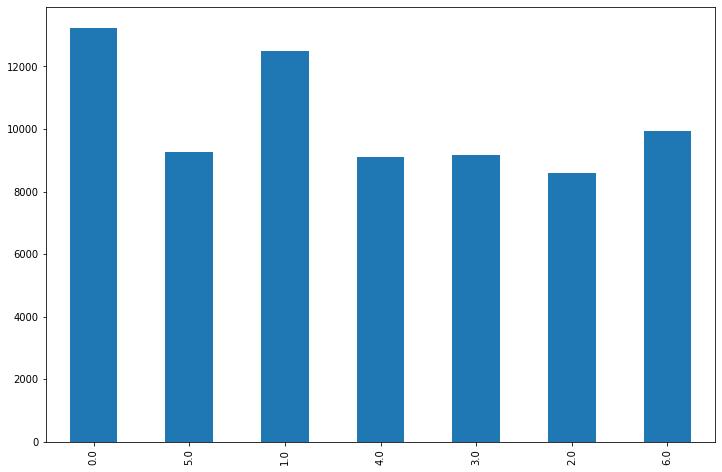

In [30]:
# Visualizing most frequent order days

orders_products['order_dow'].value_counts(sort=False).plot.bar(figsize=(12,8));

In [31]:
# Percentage of reorders from priors df

orders_products['reordered'].sum()/orders_products.shape[0]

0.5976010699061046

## Feature Engineering

### Product Features 

In [32]:
# # group = df['Data3'].groupby(df['Date']).sum()

# # df['Data4'] = group

# group = orders_products['reordered'].groupby(orders_products['user_id']).transform('sum')

# orders_products['user_reorders'] = group 

In [33]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle,department
0,23391,7,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0,85% Lean Ground Beef,meat counter,meat seafood
1,23391,7,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0,Organic Apple Slices,fruit vegetable snacks,snacks
2,23391,7,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0,Apple Honeycrisp Organic,fresh fruits,produce
3,23391,7,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0,Mexican Coffee,coffee,beverages
4,23391,7,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0,Lactose Free Fat Free Milk,soy lactosefree,dairy eggs


In [34]:
# Calculating product_order_frequency

orders_products['product_order_freq'] = orders_products.groupby(['user_id','product_id']).cumcount() + 1

In [35]:
# Calculating total orders by product 

group = orders_products.groupby('product_id')['product_id'].transform('count')

orders_products['prd_total_orders'] = group

In [36]:
# Calculating first_orders by product

orders_products['first_orders'] = (orders_products.assign(first = orders_products['product_order_freq']
                          .where(orders_products['product_order_freq'] == 1))
                          .groupby('product_id')['first']
                          .transform('sum'))

In [37]:
# Calculating second_orders by product

orders_products['second_orders'] = (orders_products.assign(second = orders_products['product_order_freq']
                          .where(orders_products['product_order_freq'] == 2))
                          .groupby('product_id')['second']
                          .transform('sum'))

In [38]:
# Calcuating total reorders by product 

group = orders_products.groupby('product_id')['reordered'].transform('sum')

orders_products['prd_total_reorders'] = group

In [39]:
# Calculating final product features 

orders_products['prd_reorder_prob'] = orders_products['second_orders']/orders_products['first_orders']
orders_products['prd_reorder_times'] = 1 + (orders_products['prd_total_reorders']/orders_products['first_orders'])
orders_products['prd_reorder_ratio'] = orders_products['prd_total_reorders']/orders_products['prd_total_orders']
orders_products.drop(columns=['first_orders','second_orders'],inplace=True)

In [40]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle,department,product_order_freq,prd_total_orders,prd_total_reorders,prd_reorder_prob,prd_reorder_times,prd_reorder_ratio
0,23391,7,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0,85% Lean Ground Beef,meat counter,meat seafood,1,29,15.0,0.074074,1.555556,0.517241
1,23391,7,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0,Organic Apple Slices,fruit vegetable snacks,snacks,1,14,11.0,0.166667,1.916667,0.785714
2,23391,7,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0,Apple Honeycrisp Organic,fresh fruits,produce,1,203,150.0,0.173913,1.815217,0.738916
3,23391,7,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0,Mexican Coffee,coffee,beverages,1,2,2.0,0.000000,2.000000,1.000000
4,23391,7,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0,Lactose Free Fat Free Milk,soy lactosefree,dairy eggs,1,8,5.0,0.000000,1.625000,0.625000


In [41]:
orders_products.isna().sum()

order_id                     0
user_id                      0
eval_set                     0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    4615
product_id                   0
add_to_cart_order            0
reordered                    0
product_name                 0
aisle                        0
department                   0
product_order_freq           0
prd_total_orders             0
prd_total_reorders           0
prd_reorder_prob             0
prd_reorder_times            0
prd_reorder_ratio            0
dtype: int64

### User Features

In [42]:
# Calculating total orders per user 

orders_products['total_user_orders'] = orders_products.groupby('user_id')['order_number'].transform('max')

In [43]:
# Calculating total reorders per user 

group = orders_products['reordered'].groupby(orders_products['user_id']).transform('sum')

orders_products['user_reorders'] = group 

In [44]:
# Calculating total products ordered by user 

group = orders_products['order_id'].groupby(orders_products['user_id']).transform('count')

orders_products['total_user_prod_orders'] = group

In [45]:
# Calculating re-order ratio by product user 

orders_products['user_reorder_ratio'] = orders_products['user_reorders']/orders_products['total_user_prod_orders']

In [46]:
# Calculating average basket size by user 

orders_products['user_avg_bskt'] = orders_products['total_user_prod_orders']/orders_products['total_user_orders']

In [47]:
orders_products.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,prd_total_orders,prd_total_reorders,prd_reorder_prob,prd_reorder_times,prd_reorder_ratio,total_user_orders,user_reorders,total_user_prod_orders,user_reorder_ratio,user_avg_bskt
0,23391,7,prior,17.0,0.0,10.0,28.0,13198.0,1.0,1.0,...,29,15.0,0.074074,1.555556,0.517241,17.0,9.0,11,0.818182,0.647059
1,23391,7,prior,17.0,0.0,10.0,28.0,42803.0,2.0,1.0,...,14,11.0,0.166667,1.916667,0.785714,17.0,9.0,11,0.818182,0.647059
2,23391,7,prior,17.0,0.0,10.0,28.0,8277.0,3.0,1.0,...,203,150.0,0.173913,1.815217,0.738916,17.0,9.0,11,0.818182,0.647059
3,23391,7,prior,17.0,0.0,10.0,28.0,37602.0,4.0,1.0,...,2,2.0,0.000000,2.000000,1.000000,17.0,9.0,11,0.818182,0.647059
4,23391,7,prior,17.0,0.0,10.0,28.0,40852.0,5.0,1.0,...,8,5.0,0.000000,1.625000,0.625000,17.0,9.0,11,0.818182,0.647059


In [48]:
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71782 entries, 0 to 71781
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                71782 non-null  int64  
 1   user_id                 71782 non-null  int64  
 2   eval_set                71782 non-null  object 
 3   order_number            71782 non-null  float64
 4   order_dow               71782 non-null  float64
 5   order_hour_of_day       71782 non-null  float64
 6   days_since_prior_order  67167 non-null  float64
 7   product_id              71782 non-null  float64
 8   add_to_cart_order       71782 non-null  float64
 9   reordered               71782 non-null  float64
 10  product_name            71782 non-null  object 
 11  aisle                   71782 non-null  object 
 12  department              71782 non-null  object 
 13  product_order_freq      71782 non-null  int64  
 14  prd_total_orders        71782 non-null

In [49]:
# Dropping unnecessary columns ahead of modeling 

orders_model = orders_products.select_dtypes(exclude=['object'])

In [50]:
orders_model.isna().sum()

order_id                     0
user_id                      0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    4615
product_id                   0
add_to_cart_order            0
reordered                    0
product_order_freq           0
prd_total_orders             0
prd_total_reorders           0
prd_reorder_prob             0
prd_reorder_times            0
prd_reorder_ratio            0
total_user_orders            0
user_reorders                0
total_user_prod_orders       0
user_reorder_ratio           0
user_avg_bskt                0
dtype: int64

In [51]:
# Fill null values from days_since_prior_order with 0 

orders_model.fillna(0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Modeling

In [69]:
# Logistic Regression

In [52]:
# Setting up target and features 

X = orders_model.drop(columns='reordered')
y = orders_model['reordered']

In [53]:
# Setting up train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50,random_state=42)

In [54]:
# Scaling data for logreg model

log_scaler = StandardScaler()


# Fit and transform train, transform test

X_train_scaled = log_scaler.fit_transform(X_train)
X_test_scaled = log_scaler.transform(X_test)

In [55]:
# Instantiating model 

log_model = LogisticRegression(penalty='l2', 
                               C=2, 
                               class_weight='balanced', 
                               solver='lbfgs',
                               random_state=42) 

In [56]:
# Fit model on train 

log_model.fit(X_train_scaled,y_train)

LogisticRegression(C=2, class_weight='balanced', random_state=42)

In [57]:
# Printing train results 

y_pred_train = log_model.predict(X_train_scaled)


train_accuracy = accuracy_score(y_train,y_pred_train)
train_precision = precision_score(y_train,y_pred_train)
train_recall = recall_score(y_train,y_pred_train)
train_f1 = f1_score(y_train,y_pred_train)

print(f"""\
Accuracy:{train_accuracy:1.2f}, Precision:{train_precision:1.2f},Recall:{train_recall:1.2f},F1:{train_f1:1.2f}
""") 

Accuracy:0.84, Precision:0.88,Recall:0.85,F1:0.86



In [59]:
y_pred_test = log_model.predict(X_test_scaled)


model_precision = precision_score(y_test,y_pred_test)
model_accuracy = accuracy_score(y_test,y_pred_test)
model_f1 = f1_score(y_test,y_pred_test)
model_recall = recall_score(y_test,y_pred_test)




print(f"""\
Accuracy:{model_accuracy:1.2f},Precision:{model_precision:1.2f}, Recall:{model_recall:1.2f},F1:{model_f1:1.2f}
""") 

Accuracy:0.84,Precision:0.87, Recall:0.85,F1:0.86



In [61]:
from sklearn.model_selection import GridSearchCV

# Setting up paramaters for GridSearch

params = {
    'penalty': ['l1', 'l2', 'elasticnet']
    ,'C': [100, 10, 1.0, 0.1, 0.01]
    ,'solver': ['saga','sag','lbfgs'] 
    ,'max_iter': [100, 500, 1000]
}

In [ ]:
# # GridSearch

# grid = GridSearchCV(log_model,
#                    param_grid = params,
#                    cv = 5,
#                    n_jobs = -2)

# grid.fit(X_train_scaled,y_train)

In [63]:
# Grabbing best parameters for logreg model

grid.best_params_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [64]:
# {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [65]:
# Instantiating second model with best parameters 

log_model_2 = LogisticRegression(C=.1,max_iter=100,penalty='l1',solver='saga',class_weight='balanced',\
                                 random_state=42)

In [66]:
log_model_2.fit(X_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=42, solver='saga')

In [67]:
# Printing train results 

y_pred_train = log_model.predict(X_train_scaled)


train_accuracy = accuracy_score(y_train,y_pred_train)
train_precision = precision_score(y_train,y_pred_train)
train_recall = recall_score(y_train,y_pred_train)
train_f1 = f1_score(y_train,y_pred_train)

print(f"""\
Accuracy:{train_accuracy:1.2f}, Precision:{train_precision:1.2f},Recall:{train_recall:1.2f},F1:{train_f1:1.2f}
""") 

Accuracy:0.84, Precision:0.88,Recall:0.85,F1:0.86



In [68]:
y_pred_test = log_model.predict(X_test_scaled)


model_precision = precision_score(y_test,y_pred_test)
model_accuracy = accuracy_score(y_test,y_pred_test)
model_f1 = f1_score(y_test,y_pred_test)
model_recall = recall_score(y_test,y_pred_test)




print(f"""\
Accuracy:{model_accuracy:1.2f},Precision:{model_precision:1.2f}, Recall:{model_recall:1.2f},F1:{model_f1:1.2f}
""") 

Accuracy:0.84,Precision:0.87, Recall:0.85,F1:0.86



In [70]:
# XGBoost 
import xgboost


[0]	train-logloss:0.643151
[10]	train-logloss:0.417536
[20]	train-logloss:0.352414
[30]	train-logloss:0.327452
[40]	train-logloss:0.315325
[50]	train-logloss:0.307837
[60]	train-logloss:0.302534
[70]	train-logloss:0.298418
[79]	train-logloss:0.296106


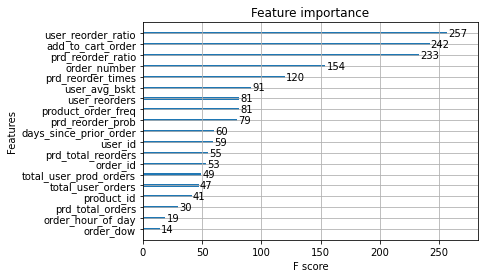

In [71]:
# Instantiate and train model

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst);

In [76]:
#setting boosters parameters

parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

In [79]:
import xgboost as xgb

# #Initializing the model
xgb = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

#fitting the model.
xgb.fit(X_train, y_train)

#prediction
y_pred = (xgb.predict_proba(X_test)[:, 1] >= 0.21).astype('int') #setting a threshold.

#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))

F1 Score: 0.8567781672305853
